In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

### Read-in and explore the dataset

In [2]:
# extract the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')

In [3]:
# examine the data
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,self.jokes,NaN,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,self.jokes,NaN,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh...,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg...,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [4]:
df.shape

(1000000, 12)

In [5]:
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

In [6]:
# define some parameters 
CLASS_SIZE = 20000

In [7]:
# boolean masks

# where selftext isnull (no punchline)
is_null = df['selftext'].isnull()

# where title or post were removed by reddit user/mod
removed = (df['selftext'] == '[removed]') | (df['title'] == '[removed]')

# where tile or post were deleted by the original poster
deleted = (df['selftext'] == '[deleted]') | (df['title'] == '[deleted]')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

In [8]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted]
df_cleaned.shape

<ipython-input-8-cf863a65bca4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleaned = df[~removed][~deleted]


(578634, 12)

In [9]:
# find the score that gives the closest number of positive class instances to the CLASS SIZE
min_length = np.inf
best_score_for_binary_class = 0
for score in range(450,500):
    length = len(df_cleaned[df['score'] > score])
    length = np.abs(CLASS_SIZE - length)
    if min_length > length:
        min_length = length
        best_score_for_binary_class = score
# create mask of best score for binary classification         
pos_class = df_cleaned['score'] > best_score_for_binary_class
# update class size to reflect positive class size
updated_class_size = len(df_cleaned[pos_class])

<ipython-input-9-8d35be748270>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  length = len(df_cleaned[df['score'] > score])


### Objective: Make the positive and negative class labels and concatenate the dataframe

In [10]:
# create target label
df_cleaned['target'] = pos_class
# concatenate the datafame
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class]], axis=0)

<ipython-input-10-1d26d5cc7863>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class]], axis=0)


### Objective: Explore the Data
1. Convert Datetime to time series and plot number of submissions over time

In [11]:
# making unix created_times into readable timestamps
def make_tz_timestamp(unix_ts, tz='US/Eastern'):
    from datetime import datetime
    import pytz
    timezone = pytz.timezone(tz)
    # convert unix utc to timestamp utc
    ts = datetime.utcfromtimestamp(unix_ts)
    # return is to that it is tz-aware
    #return timezone.localize(ts)
    return ts

In [12]:
df_concat['created_at'] = df_concat['created_utc'].apply(lambda x: make_tz_timestamp(x))

In [13]:
# explore the time series 
start_date, end_date = df_concat['created_at'].min(), df_concat['created_at'].max()

Text(0, 0.5, 'number of submissions')

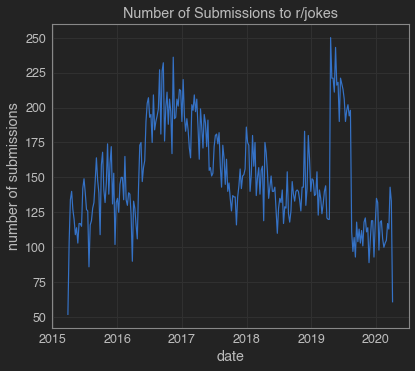

In [22]:
# look at submissions
data = df_concat.set_index('created_at', drop=True).resample('W').count()
sns.lineplot(x=data.index, y='type', data=data)
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')

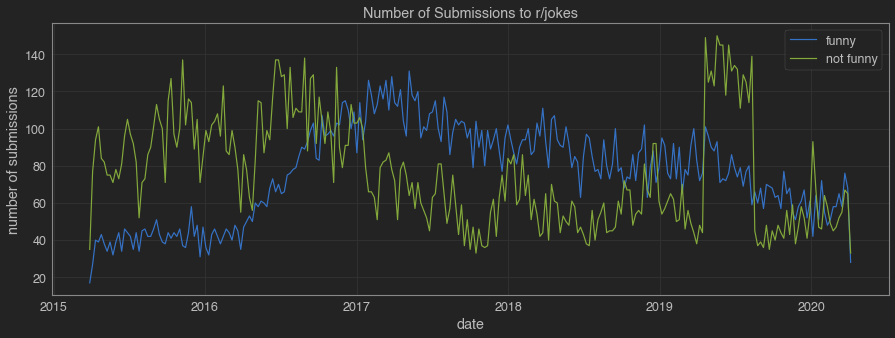

In [26]:
# look at submissions
plt.figure(figsize=(15, 5))
data_good = df_concat[df_concat['target']==True].set_index('created_at', drop=True).resample('W').count()
data_bad = df_concat[df_concat['target']==False].set_index('created_at', drop=True).resample('W').count()
sns.lineplot(x=data_good.index, y='type', data=data_good, label='funny')
sns.lineplot(x=data_bad.index, y='type', data=data_bad, label='not funny')
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')
plt.legend()
plt.show()